# Data preparation notebook
I used a different benchmarking library that returns .json files for the results outputs. These are more granular results and will allow us to more accurately time the prefill and decode metrics.

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

In [22]:
def analyze_benchmark_results(json_file):
    # Load the benchmark results
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Create DataFrame for analysis
    results = []
    
    if 'ttfts' in data and 'input_lens' in data and 'output_lens' in data and 'itls' in data:
        for i in range(len(data['ttfts'])):
            if i < len(data['input_lens']) and i < len(data['output_lens']):
                if data['ttfts'][i] is not None: 
                    prefill_time = data['ttfts'][i] 
                    e2e_latency = data.get('e2el', [])[i] if 'e2el' in data else None
                    if e2e_latency is not None:
                        decode_time = e2e_latency - prefill_time
                    else:
                        itls_for_request = data['itls'][i] if isinstance(data['itls'][i], list) else []
                        decode_time = sum(itls_for_request) if itls_for_request else 0
                    print(decode_time)
                    # Calculate metrics you're interested in
                    results.append({
                        'input_tokens': data['input_lens'][i],
                        'output_tokens': data['output_lens'][i],
                        'prefill_time': prefill_time,
                        'decode_time': decode_time,
                        'ttft_ms': prefill_time * 1000,  # Convert to ms
                        'e2e_latency': e2e_latency if e2e_latency is not None else (prefill_time + decode_time),
                        'prefill_throughput': data['input_lens'][i] / prefill_time if prefill_time else 0,
                        'decode_throughput': data['output_lens'][i] / decode_time if decode_time else 0
                    })
    else:
        # We only have aggregated statistics
        print("Detailed per-request data not available. Using aggregated statistics.")
        
        # Extract aggregate metrics
        prefill_time_ms = data.get('median_ttft_ms', 0)
        e2e_latency_ms = data.get('median_e2el_ms', 0)
        decode_time_ms = e2e_latency_ms - prefill_time_ms
        
        results.append({
            'prefill_time': prefill_time_ms / 1000,  # Convert to seconds
            'decode_time': decode_time_ms / 1000,
            'ttft_ms': prefill_time_ms,
            'e2e_latency': e2e_latency_ms / 1000
        })
    
    # Reconstruct time steps of request sent from the results using poisson distribution
    time_steps = []
    time = 0
    poisson_rate = 2.0
    for i in range(len(results)):
        time += np.random.exponential(1.0 / poisson_rate)
        time_steps.append(time)
    for i in range(len(results)):
        results[i]['time_step'] = time_steps[i]
    df = pd.DataFrame(results)
    return df

In [23]:
df = analyze_benchmark_results("/Users/grantwilkins/powertrace-sim/client/vllm-2.0qps-tp2-Llama-3.1-8B-Instruct-20250506-091241.json")
print(df.head())

0.930956830001378
6.389684415000374
1.943036826000025
1.6379206979981973
0.8508948669987149
6.202499186998466
0.0686982179977349
0.19958229600160848
0.04194593300053384
0.6665776369991363
3.2899913450019085
0.6983938460034551
3.3395624900003895
0.37129010599892354
2.458667240003706
0.06908041400311049
1.4691190500016091
2.340000272997713
2.7712149169965414
0.3023808590005501
4.875744040000427
3.1485735089954687
1.3565556190005736
1.1555125230006524
0.2894244900016929
0.38182238199806307
3.7310160320048453
0.983660226003849
1.8913936009994359
0.025283023998781573
0.03372063999995589
1.2241972050032928
0.4902656760023092
0.08573695599625353
4.778004821993818
1.6001219959944137
4.395430763004697
1.089367176995438
0.1039796179975383
1.9032755559965153
1.6077462670000386
0.13054830500186654
0.2959105699992506
2.342545966996113
1.70044538500224
4.102507474999584
2.043613378998998
1.107211925998854
0.21542868799588177
1.9717406919953646
0.13916953800071497
1.7186030419979943
0.086721893996582

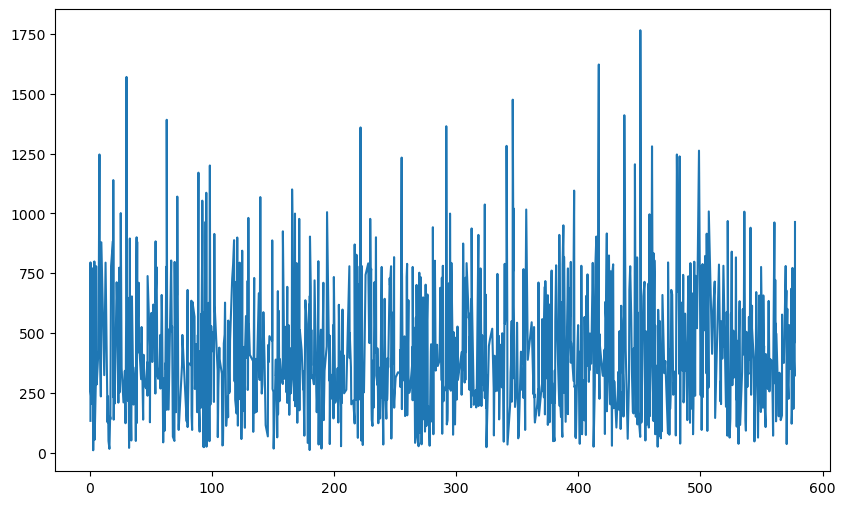

In [24]:
# Plotting
plt.figure(figsize=(10, 6))
df["total_tokens"] = df["input_tokens"] + df["output_tokens"]
# sns.scatterplot(x="total_tokens", y="decode_time", data=df)
# sns.scatterplot(x="total_tokens", y="prefill_time", data=df, color='red')
plt.plot(df["time_step"], df["total_tokens"])

## Renaming file block (be careful to not overwrite the original files):

In [4]:
import re
from pathlib import Path
from datetime import datetime

# CLIENT_DIR = Path('/Users/grantwilkins/powertrace-sim/client')

# # parses JSON filenames
# json_re = re.compile(
#     r'''^vllm-
#         (?P<qps>[\d.]+)qps
#         -tp(?P<tp>\d+)
#         -(?P<raw_model>.+?)
#         -(?P<json_dt>\d{8}-\d{6})
#         \.json$
#     ''', re.VERBOSE
# )

# # map JSON model → CSV model
# model_map = {
#     'Llama-3.1-8B-Instruct': 'llama-3-8b',
#     # add more if you have other models
# }

# # parses CSV filenames and pulls out their datetime
# csv_re = re.compile(r'_d(?P<csv_dt>\d{4}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2})\.csv$')

# for json_path in CLIENT_DIR.glob('vllm-*qps-tp*-*.json'):
#     m = json_re.match(json_path.name)
#     if not m:
#         continue

#     qps       = m.group('qps')               # e.g. "0.5"
#     tp        = m.group('tp')                # e.g. "1"
#     raw_model = m.group('raw_model')         # e.g. "Llama-3.1-8B-Instruct"
#     jdt_str   = m.group('json_dt')           # e.g. "20250506-013048"

#     # JSON timestamp → datetime
#     json_dt = datetime.strptime(jdt_str, '%Y%m%d-%H%M%S')

#     # determine CSV-model name
#     model_csv = model_map.get(raw_model,
#                               raw_model.lower()
#                                      .replace('.', '')
#                                      .replace('-instruct',''))

#     # gather all candidate CSVs
#     pattern = f"{model_csv}_tp{tp}_p{qps}_d*.csv"
#     candidates = []
#     for csv_path in CLIENT_DIR.glob(pattern):
#         cm = csv_re.search(csv_path.name)
#         if not cm:
#             continue
#         cdt_str = cm.group('csv_dt')  # "2025-05-06-01-20-27"
#         csv_dt  = datetime.strptime(cdt_str, '%Y-%m-%d-%H-%M-%S')
#         delta   = (json_dt - csv_dt).total_seconds()
#         if delta > 0:
#             candidates.append((delta, csv_path, csv_dt))

#     if not candidates:
#         print(f"No CSV found for {json_path.name}")
#         continue

#     # pick the CSV with the smallest positive delta
#     _, best_csv, _ = min(candidates, key=lambda x: x[0])

#     # build new CSV name with JSON timestamp (reformatted)
#     new_dt_str = json_dt.strftime('%Y%m%d-%H%M%S')
#     new_name   = f"{model_csv}_tp{tp}_p{qps}_d{new_dt_str}.csv"

#     best_csv.rename(best_csv.with_name(new_name))
#     print(f"{best_csv.name} → {new_name}")


llama-3-8b_tp4_p1.0_d2025-05-06-12-01-21.csv → llama-3-8b_tp4_p1.0_d20250506-121144.csv
llama-3-8b_tp4_p4.0_d2025-05-06-16-32-23.csv → llama-3-8b_tp4_p4.0_d20250506-164301.csv
llama-3-8b_tp2_p0.125_d2025-05-06-08-20-40.csv → llama-3-8b_tp2_p0.125_d20250506-083109.csv
llama-3-8b_tp8_p2.0_d2025-05-06-20-34-27.csv → llama-3-8b_tp8_p2.0_d20250506-204449.csv
llama-3-8b_tp2_p2.0_d2025-05-06-06-56-54.csv → llama-3-8b_tp2_p2.0_d20250506-070717.csv
llama-3-8b_tp4_p0.125_d2025-05-06-12-32-45.csv → llama-3-8b_tp4_p0.125_d20250506-124313.csv
llama-3-8b_tp1_p2.0_d2025-05-06-04-49-51.csv → llama-3-8b_tp1_p2.0_d20250506-050017.csv
llama-3-8b_tp4_p0.125_d2025-05-06-14-37-52.csv → llama-3-8b_tp4_p0.125_d20250506-144820.csv
llama-3-8b_tp4_p1.0_d2025-05-06-15-09-02.csv → llama-3-8b_tp4_p1.0_d20250506-151925.csv
llama-3-8b_tp2_p2.0_d2025-05-06-11-07-41.csv → llama-3-8b_tp2_p2.0_d20250506-111804.csv
llama-3-8b_tp1_p2.0_d2025-05-06-02-44-09.csv → llama-3-8b_tp1_p2.0_d20250506-025434.csv
llama-3-8b_tp2_p4.0_

In [55]:
import glob
import re
from typing import List, Tuple, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

def calculate_token_workload_efficient(power_df, results_df):
    """
    Efficiently calculate token workload at each power timestamp using vectorized operations.
    
    Args:
        power_df: DataFrame with power measurements and timestamps
        results_df: DataFrame with benchmark results
        
    Returns:
        Updated power_df with token workload columns
    """
    # Create copies to avoid modifying originals
    power_df = power_df.copy()
    
    # Initialize new columns
    power_df['prefill_tokens'] = 0
    power_df['decode_tokens'] = 0
    power_df['active_requests'] = 0
    
    # Pre-compute phase boundaries for all requests
    results_df['prefill_start'] = results_df['request_timestamp']
    results_df['prefill_end'] = results_df['prefill_start'] + results_df['prefill_time']
    results_df['decode_end'] = results_df['prefill_end'] + results_df['decode_time']
    
    # For each timestamp in power_df (still need to iterate but avoid nested loop)
    for idx, row in power_df.iterrows():
        current_time = row['timestamp']
        
        # Find active requests at this timestamp (vectorized operation)
        active_mask = (results_df['prefill_start'] <= current_time) & (current_time <= results_df['decode_end'])
        active_requests = results_df[active_mask]
        
        # Find requests in prefill vs decode phase (vectorized operations)
        prefill_mask = (current_time <= results_df['prefill_end']) & active_mask
        decode_mask = (current_time > results_df['prefill_end']) & active_mask
        
        # Sum tokens in each phase (vectorized operations)
        prefill_tokens = results_df.loc[prefill_mask, 'input_tokens'].sum()
        decode_tokens = results_df.loc[decode_mask, 'output_tokens'].sum()
        
        # Update the power_df with counts
        power_df.at[idx, 'prefill_tokens'] = prefill_tokens
        power_df.at[idx, 'decode_tokens'] = decode_tokens
        power_df.at[idx, 'active_requests'] = len(active_requests)
    
    return power_df

def discover_experiment_pairs(data_root_dir: str) -> List[Tuple[str, str]]:
    """
    Finds matching pairs of power CSVs and results CSVs based on
    {MODEL_NAME}_tp{TP}_p{RATE}_d{DATE}.csv and
    results_{MODEL_NAME}_{RATE}_{TP}_d{DATE}_final.csv.

    Returns:
        A list of (power_csv_path, results_csv_path).
    """
    all_csvs = glob.glob(
        os.path.join(data_root_dir, "**", "*.csv"), recursive=True
    )
    all_jsons = glob.glob(
        os.path.join(data_root_dir, "**", "*.json"), recursive=True
    )
    print(f"Found {len(all_csvs)} CSV files in {data_root_dir}")

    power_files = []
    results_files = []

    for csv_path in all_csvs:
        base = os.path.basename(csv_path)
        if "_tp" in base and "_p" in base:
            power_files.append(csv_path)
        else:
            print(f"Skipping power file {csv_path} as it doesn't match expected pattern")
    
    for json_path in all_jsons:
        base = os.path.basename(json_path)
        if "vllm-" in base:
            results_files.append(json_path)
        else:
            print(f"Skipping results file {json_path} as it doesn't match expected pattern")
                

    print(f"Found {len(power_files)} power files and {len(results_files)} results files")

    matched_pairs = []
    for pfile in power_files:
        pinfo = extract_power_info(pfile)
        if not pinfo:
            continue
        p_model, p_tp, p_rate, p_date = pinfo

        # Look for a results file that matches
        for rfile in results_files:
            rinfo = extract_results_info(rfile)
            if not rinfo:
                continue
            r_model, r_tp, r_rate, r_date = rinfo

            # Check if they match on model, tp, and rate
            if p_model == r_model and p_tp == r_tp and p_rate == r_rate:
                if p_date and r_date:
                    if p_date == r_date:
                        matched_pairs.append((pfile, rfile))
                        break  
                else:
                    matched_pairs.append((pfile, rfile))
                    break 

    print(
        f"Found {len(power_files)} power files, {len(results_files)} results files, "
        f"matched {len(matched_pairs)} pairs."
    )
    return matched_pairs

def extract_results_info(filename: str):
    base = os.path.basename(filename)
    result_match = re.match(r"vllm-([\d\.]+)qps-tp(\d+)-Llama-3.1-(\d+)B-Instruct-(.*).json", base)
    if result_match:
        rate = result_match.group(1)
        tp = result_match.group(2)
        model_size = result_match.group(3)
        date = result_match.group(4)
    return model_size, tp, rate, date

def extract_power_info(filename: str):
    base = os.path.basename(filename)
    model_match = re.match(r"llama-3-(\d+)b_tp(\d+)_p([\d\.]+)_d(.*).csv", base)
    if not model_match:
        return None
    model_size = model_match.group(1)
    tp = model_match.group(2)
    rate = model_match.group(3)
    date = model_match.group(4)
    return model_size, tp, rate, date

def analyze_benchmark_results(json_file: str) -> pd.DataFrame:
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    results = []

    experiment_info = extract_results_info(json_file)
    model_size = int(experiment_info[0])  # Extracted model size from the filename
    tp = int(experiment_info[1])  # Extracted tensor parallelism from the filename
    poisson_rate = float(experiment_info[2])  # Extracted rate from the filename

    if 'ttfts' in data and 'input_lens' in data and 'output_lens' in data and 'itls' in data:
        for i in range(len(data['ttfts'])):
            if i < len(data['input_lens']) and i < len(data['output_lens']):
                if data['ttfts'][i] is not None: 
                    prefill_time = data['ttfts'][i] 
                    e2e_latency = data.get('e2el', [])[i] if 'e2el' in data else None
                    if e2e_latency is not None:
                        decode_time = e2e_latency - prefill_time
                    else:
                        itls_for_request = data['itls'][i] if isinstance(data['itls'][i], list) else []
                        decode_time = sum(itls_for_request) if itls_for_request else 0
                    print(decode_time)
                    # Calculate metrics you're interested in
                    results.append({
                        'input_tokens': data['input_lens'][i],
                        'output_tokens': data['output_lens'][i],
                        'prefill_time': prefill_time,
                        'decode_time': decode_time,
                        'ttft_ms': prefill_time * 1000,  # Convert to ms
                        'e2e_latency': e2e_latency if e2e_latency is not None else (prefill_time + decode_time),
                        'prefill_throughput': data['input_lens'][i] / prefill_time if prefill_time else 0,
                        'decode_throughput': data['output_lens'][i] / decode_time if decode_time else 0,
                        'model_size': model_size,
                        'tp': tp,
                        'poisson_rate': poisson_rate
                    })
    else:
        # We only have aggregated statistics
        print("Detailed per-request data not available. Using aggregated statistics.")
        
        # Extract aggregate metrics
        prefill_time_ms = data.get('median_ttft_ms', 0)
        e2e_latency_ms = data.get('median_e2el_ms', 0)
        decode_time_ms = e2e_latency_ms - prefill_time_ms
        
        results.append({
            'prefill_time': prefill_time_ms / 1000,  # Convert to seconds
            'decode_time': decode_time_ms / 1000,
            'ttft_ms': prefill_time_ms,
            'e2e_latency': e2e_latency_ms / 1000
        })
    
    # Reconstruct time steps of request sent from the results using poisson distribution
    time_steps = []
    time = 0
    for i in range(len(results)):
        time += np.random.exponential(1.0 / poisson_rate)
        time_steps.append(time)
    for i in range(len(results)):
        results[i]['time_step'] = time_steps[i]
    df = pd.DataFrame(results)

    return df


def parse_power_csv(csv_path: str) -> pd.DataFrame:
    """
    Parse the GPU power trace CSV and sum up the first X power values of each group of 8 rows,
    where X is the tensor parallelism extracted from the filename (_tpX).
    The timestamp for each sample is taken as the minimum timestamp within the group.
    
    Expects columns (for each GPU row):
        timestamp, power.draw [W], utilization.gpu [%], memory.used [MiB]
    """
    try:
        # Read CSV and clean up column names
        df = pd.read_csv(csv_path, skipinitialspace=True)
        df.columns = [col.strip().lower() for col in df.columns]

        if "power.draw [w]" in df.columns:
            df.rename(columns={"power.draw [w]": "power"}, inplace=True)
            df.rename(columns={"memory.used [mib]": "memory"}, inplace=True)
        if df["power"].dtype == object:
            df["power"] = df["power"].replace(r"[^\d.]", "", regex=True)
            df["power"] = pd.to_numeric(df["power"])
        if "memory" in df.columns and df["memory"].dtype == object:
            df["memory"] = df["memory"].replace(r"[^\d.]", "", regex=True)
            df["memory"] = pd.to_numeric(df["memory"])

        time_col = None
        for c in df.columns:
            if "time" in c:
                time_col = c
                break
        if not time_col:
            raise ValueError("No timestamp column found in power CSV")
        df[time_col] = pd.to_datetime(df[time_col])
        df.rename(columns={time_col: "timestamp"}, inplace=True)

        tp_match = re.search(r'_tp(\d+)', csv_path)
        tensor_parallelism = int(tp_match.group(1)) if tp_match else 1
        print(f"Extracted tensor parallelism {tensor_parallelism} from {csv_path}")
        
        # Group by 8 rows (8 GPUs per node)
        num_rows = len(df)
        num_complete_groups = num_rows // 8
        df = df.iloc[:num_complete_groups * 8]
        groups = df.groupby(np.arange(len(df)) // 8)

        result = groups.apply(lambda x: pd.Series({
            "timestamp": x["timestamp"].min(),
            "power": x.iloc[:tensor_parallelism]["power"].sum()
        })).reset_index(drop=True)

        result["timestamp"] = pd.to_datetime(result['timestamp']).astype(np.int64) / 10**9

        return result

    except Exception as e:
        print(f"Error reading power file {csv_path}: {e}")
        return pd.DataFrame()


def extract_experiment_info(power_csv_path: str):
    """
    Extract experiment information from the power CSV filename.
    
    Args:
        power_csv_path: Path to the power CSV file
        
    Returns:
        Dict with model_name, tp, rate, and date
    """
    base = os.path.basename(power_csv_path)
    model_match = re.match(r"(.*)_tp(\d+)_p([\d\.]+)_d(.*).csv", base)
    if not model_match:
        return None
    
    return {
        "model_name": model_match.group(1),
        "tp": int(model_match.group(2)),
        "rate": float(model_match.group(3)),
        "date": model_match.group(4)
    }


def load_and_process_experiments(data_root_dir: str, exclude_patterns=None):
    """
    Load and process all experiment pairs, organizing them into coordinated lists.
    
    Args:
        data_root_dir: Root directory to search for CSV files
        exclude_patterns: List of patterns to exclude (e.g., ['deepseek'])
        
    Returns:
        power_dfs: List of power dataframes with token workload information
        results_dfs: List of results dataframes with aligned timestamps
        experiment_info: List of dictionaries with experiment metadata
    """
    # Find matching experiment pairs
    matched_pairs = discover_experiment_pairs(data_root_dir)
    
    # Filter out excluded patterns
    if exclude_patterns:
        filtered_pairs = []
        for pair in matched_pairs:
            should_include = True
            for pattern in exclude_patterns:
                if (pattern.lower() in pair[0].lower() or 
                    pattern.lower() in pair[1].lower()):
                    should_include = False
                    break
            if should_include:
                filtered_pairs.append(pair)
        
        print(f"Filtered out {len(matched_pairs) - len(filtered_pairs)} pairs. Remaining pairs: {len(filtered_pairs)}")
        matched_pairs = filtered_pairs
    
    # Process each pair
    power_dfs = []
    results_dfs = []
    experiment_info = []
    
    for power_csv, results_json in matched_pairs:
        print(f"Processing {power_csv} and {results_json}")
        
        # Extract experiment information
        info = extract_experiment_info(power_csv)
        if not info:
            print(f"Could not extract experiment info from {power_csv}")
            continue
        
        # Parse CSV files
        power_df = parse_power_csv(power_csv)
        results_df = analyze_benchmark_results(results_json)
        
        # Skip if parsing failed
        if power_df.empty or results_df.empty:
            print(f"Skipping empty dataframes for {power_csv} and {results_json}")
            continue
        
        # Align timestamps of results with power data
        results_df = align_request_timestamps(results_df, power_df, info['rate'])
        
        # Calculate token workload for each power timestamp
        power_df = calculate_token_workload_efficient(power_df, results_df)
        
        # Add to our lists
        power_dfs.append(power_df)
        results_dfs.append(results_df)
        experiment_info.append(info)
    
    print(f"Successfully processed {len(power_dfs)} experiment pairs")
    return power_dfs, results_dfs, experiment_info

def align_request_timestamps(results_df, power_df, poisson_rate):
    """
    Generate synthetic timestamps for requests using a Poisson process,
    aligned with the min and max timestamps from the power measurements.
    
    Args:
        results_df: DataFrame with benchmark results
        power_df: DataFrame with power measurements and timestamps
        poisson_rate: Rate parameter for the Poisson process (requests per second)
        
    Returns:
        Updated results_df with aligned timestamps
    """
    # Get min and max timestamps from power data
    min_timestamp = power_df['timestamp'].min()
    max_timestamp = power_df['timestamp'].max()
    time_range = max_timestamp - min_timestamp
    
    # Check if there are already timestamps
    if 'time_step' in results_df.columns:
        # Scale existing relative timestamps to actual time range
        # We need to get the maximum relative timestamp
        max_relative = results_df['time_step'].max()
        results_df['request_timestamp'] = min_timestamp + (results_df['time_step'] / max_relative) * time_range
    else:
        # Generate new timestamps using Poisson process
        num_requests = len(results_df)
        
        # Method 1: Generate using interarrival times
        timestamps = []
        current_time = min_timestamp
        
        for _ in range(num_requests):
            # Generate interarrival time from exponential distribution
            interarrival = np.random.exponential(1.0 / poisson_rate)
            current_time += interarrival
            
            # Ensure we don't go beyond max timestamp
            if current_time > max_timestamp:
                current_time = min_timestamp + (current_time - min_timestamp) % time_range
                
            timestamps.append(current_time)
        
        # Sort timestamps to maintain Poisson property
        timestamps.sort()
        
        # Add to results DataFrame
        results_df['request_timestamp'] = timestamps
    
    # Convert to datetime format for easier analysis
    results_df['request_datetime'] = pd.to_datetime(results_df['request_timestamp'], unit='s')
    
    return results_df

def plot_power_val(df: pd.DataFrame, title: str, ylabel: str, xlabel: str, save_path: Optional[str] = None):
    plt.figure(figsize=(12, 6))
    plt.plot(df["timestamp"], df["power"], label="Power")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()  # Fixed from plt.legCompletion()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [56]:
all_power_dfs, all_results_dfs, all_experiment_info = load_and_process_experiments(
    "/Users/grantwilkins/powertrace-sim/client/benchmark-llama-3-8b",
)


Found 120 CSV files in /Users/grantwilkins/powertrace-sim/client/benchmark-llama-3-8b
Found 120 power files and 120 results files
Found 120 power files, 120 results files, matched 120 pairs.
Processing /Users/grantwilkins/powertrace-sim/client/benchmark-llama-3-8b/llama-3-8b_tp4_p4.0_d20250506-154025.csv and /Users/grantwilkins/powertrace-sim/client/benchmark-llama-3-8b/vllm-4.0qps-tp4-Llama-3.1-8B-Instruct-20250506-154025.json
Extracted tensor parallelism 4 from /Users/grantwilkins/powertrace-sim/client/benchmark-llama-3-8b/llama-3-8b_tp4_p4.0_d20250506-154025.csv
0.687844596002833
4.8073324779979885
1.4456672499945853
1.2114324160065735
0.6313028709992068
4.663669134999509
0.05081735900603235
0.14536322199273854
0.031596950997482054
0.495695332007017
2.4708440649992554
0.5230144249944715
2.4999553709931206
0.27766837300441694
1.8380847020016517
0.05149973901279736
1.0929659309913404
1.7487149919907097
2.1010584070027107
0.22925045900046825
3.6975970580097055
2.345996288000606
0.99899

      timestamp  power  prefill_tokens  decode_tokens  active_requests
0  1.746503e+09  82.29               0              0                0
1  1.746503e+09  82.20               0              0                0
2  1.746503e+09  68.55               0              0                0
3  1.746503e+09  68.55               0            120                1
4  1.746503e+09  68.55               0            120                1
12


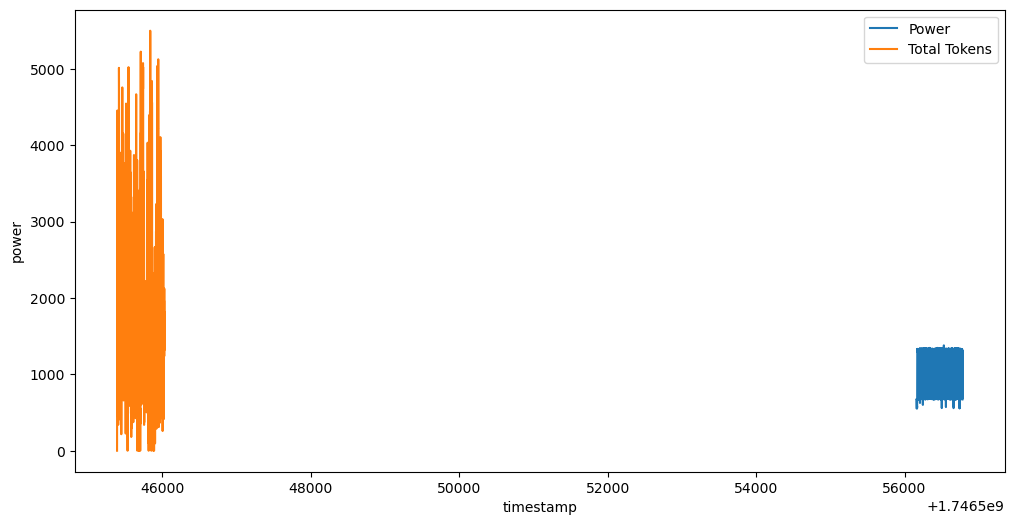

In [70]:
import statsmodels.api as sm

# sns.lineplot(x="input_tokens", y="prefill_time", data=all_results_dfs[0], label="Prefill Time")


In [80]:
power_output_path = "processed_data/power_trace_data.npz"
print(all_results_dfs[0].columns)

timestamps = [] # from power_df
prefill_tokens = [] # from power_df
decode_tokens = [] # from power_df
active_requests = [] # from power_df
input_tokens = [] # from results_df
output_tokens = [] # from results_df
ttfts = [] # from results_df
e2e_latencies = [] # from results_df
prefill_times = [] # from results_df
decode_times = [] # from results_df
prefill_throughputs = [] # from results_df
decode_throughputs = [] # from results_df
request_timestamps = [] # from results_df

tensor_parallelism = []
poisson_rate = []
model_sizes = [] 
power_traces = []
hardware = []

max_len_power = max([len(df) for df in all_power_dfs])
max_len_results = max([len(df) for df in all_results_dfs])

for i in range(len(all_power_dfs)):
    power_df = all_power_dfs[i]
    results_df = all_results_dfs[i]
    info = all_experiment_info[i]

    # pad power trace to max_len with edge values
    power_trace = power_df['power'].values
    power_trace = np.pad(power_trace, (0, max_len_power - len(power_trace)), mode='edge')
    timestamp_arr = power_df['timestamp'].values
    timestamp_arr = np.pad(timestamp_arr, (0, max_len_power - len(timestamp_arr)), mode='linear_ramp')
    prefill_tokens_arr = power_df['prefill_tokens'].values
    prefill_tokens_arr = np.pad(prefill_tokens_arr, (0, max_len_power - len(prefill_tokens_arr)), mode='edge')
    decode_tokens_arr = power_df['decode_tokens'].values
    decode_tokens_arr = np.pad(decode_tokens_arr, (0, max_len_power - len(decode_tokens_arr)), mode='edge')
    active_requests_arr = power_df['active_requests'].values
    active_requests_arr = np.pad(active_requests_arr, (0, max_len_power - len(active_requests_arr)), mode='edge')

    input_tokens_arr = results_df['input_tokens'].values
    input_tokens_arr = np.pad(input_tokens_arr, (0, max_len_results - len(input_tokens_arr)), mode='constant', constant_values=0)
    output_tokens_arr = results_df['output_tokens'].values
    output_tokens_arr = np.pad(output_tokens_arr, (0, max_len_results - len(output_tokens_arr)), mode='constant', constant_values=0)
    ttft_arr = results_df['ttft_ms'].values
    ttft_arr = np.pad(ttft_arr, (0, max_len_results - len(ttft_arr)), mode='constant', constant_values=0)
    e2e_latency_arr = results_df['e2e_latency'].values
    e2e_latency_arr = np.pad(e2e_latency_arr, (0, max_len_results - len(e2e_latency_arr)), mode='constant', constant_values=0)
    prefill_time_arr = results_df['prefill_time'].values
    prefill_time_arr = np.pad(prefill_time_arr, (0, max_len_results - len(prefill_time_arr)), mode='constant', constant_values=0)
    decode_time_arr = results_df['decode_time'].values
    decode_time_arr = np.pad(decode_time_arr, (0, max_len_results - len(decode_time_arr)), mode='constant', constant_values=0)
    prefill_throughput_arr = results_df['prefill_throughput'].values
    prefill_throughput_arr = np.pad(prefill_throughput_arr, (0, max_len_results - len(prefill_throughput_arr)), mode='constant', constant_values=0)
    decode_throughput_arr = results_df['decode_throughput'].values
    decode_throughput_arr = np.pad(decode_throughput_arr, (0, max_len_results - len(decode_throughput_arr)), mode='constant', constant_values=0)
    request_timestamp_arr = results_df['request_timestamp'].values
    request_timestamp_arr = np.pad(request_timestamp_arr, (0, max_len_results - len(request_timestamp_arr)), mode='constant', constant_values=0)



    # Extract relevant data
    power_traces.append(power_trace)
    timestamps.append(timestamp_arr)
    prefill_tokens.append(prefill_tokens_arr)
    decode_tokens.append(decode_tokens_arr)
    active_requests.append(active_requests_arr)

    request_timestamps.append(request_timestamp_arr)
    ttfts.append(ttft_arr)
    prefill_times.append(prefill_time_arr)
    decode_times.append(decode_time_arr)
    e2e_latencies.append(e2e_latency_arr)
    input_tokens.append(input_tokens_arr)
    output_tokens.append(output_tokens_arr)
    prefill_throughputs.append(prefill_throughput_arr)
    decode_throughputs.append(decode_throughput_arr)
    
    tensor_parallelism.append(results_df['tp'].values[0])
    poisson_rate.append(results_df['poisson_rate'].values[0])
    model_sizes.append(results_df['model_size'].values[0])
    hardware.append("A100")


    
# convert lists to numpy arrays
timestamps = np.array(timestamps)
power_traces = np.array(power_traces)
prefill_tokens = np.array(prefill_tokens)
decode_tokens = np.array(decode_tokens)
active_requests = np.array(active_requests)


input_tokens = np.array(input_tokens)
output_tokens = np.array(output_tokens)
ttfts = np.array(ttfts)
e2e_latencies = np.array(e2e_latencies)
prefill_times = np.array(prefill_times)
decode_times = np.array(decode_times)
prefill_throughputs = np.array(prefill_throughputs)
decode_throughputs = np.array(decode_throughputs)
request_timestamps = np.array(request_timestamps)
tensor_parallelism = np.array(tensor_parallelism)
poisson_rate = np.array(poisson_rate)
model_sizes = np.array(model_sizes)
hardware = np.array(hardware)


np.savez("vllm-benchmark-llama-3-8b-power.npz", 
        timestamps=timestamps,power_traces=power_traces,prefill_tokens=prefill_tokens, decode_tokens=decode_tokens, active_requests=active_requests, input_tokens=input_tokens, output_tokens=output_tokens, ttfts=ttfts, e2e_latencies=e2e_latencies, prefill_times=prefill_times, decode_times=decode_times, prefill_throughputs=prefill_throughputs, decode_throughputs=decode_throughputs, request_timestamps=request_timestamps, tensor_parallelism=tensor_parallelism, poisson_rate=poisson_rate, model_sizes=model_sizes, hardware=hardware)

Index(['input_tokens', 'output_tokens', 'prefill_time', 'decode_time',
       'ttft_ms', 'e2e_latency', 'prefill_throughput', 'decode_throughput',
       'model_size', 'tp', 'poisson_rate', 'time_step', 'request_timestamp',
       'request_datetime', 'prefill_start', 'prefill_end', 'decode_end'],
      dtype='object')


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (120,) + inhomogeneous part.